In [67]:
import sqlite3 as lite
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import unicodedata
import re
# import pickle
import time
import sqlalchemy
from sqlalchemy import create_engine
import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize
import seaborn as sns
nltk.downloader.download('vader_lexicon')
nltk.downloader.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Gavin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gavin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [89]:
# Import the 10-K Data from the Database
db_name = "SEC_Filings.db"
table_name = "10K_Data"

engine = sqlalchemy.create_engine('sqlite:///' + db_name, execution_options={"sqlite_raw_colnames": True})
df = pd.read_sql_table(table_name, engine)

# Clean DataFrame
agri = ['0100', '0200', '0900']
fin = ['6172', '6199', '6200', '6211', '6221', '6282']
air = ['4513', '4522', '4581']
bank = ['6022', '6029', '6035', '6036', '6099']

df['Industry'] = ''
df.loc[df['SIC'].isin(agri), 'Industry'] = "Agriculture"
df.loc[df['SIC'].isin(fin), 'Industry'] = "Financial Services"
df.loc[df['SIC'].isin(air), 'Industry'] = "Aviation"
df.loc[df['SIC'].isin(bank), 'Industry'] = "Banking"

df = df.drop(['Filing_Link', 'Accession_No', 'SIC', 'Company'], axis=1)
# df = df.iloc[np.random.randint(0, len(df), size=1000)]

In [92]:
# Sentiment Analysis
# Set 'Aspect' Words
word_search_list_2 = [{'artificial intelligence': ['artificial intelligence', 'artificial-intelligence', ' ai.', ' ai,', ' ai ']},
                      {'deep learning': ['deep learning', 'deep-learning']}, 
                      {'computer vision': ['computer vision', 'computer-vision']}, 
                      'bots', 
                      'automation', 
                      {'machine learning': ['machine learning', 'machine-learning']},
                      'algorithm']
# aspects = [list(x.values())[0] if isinstance (x, dict) else x for x in word_search_list_2]

# Convert 10-K Text to String
# review_text = df['Filing_Document_Text'][0]

# State Sentiment Analyzer - Rule-based Approach
sia = SentimentIntensityAnalyzer()

# Create DataFrame to Store Output
df_backtest = pd.DataFrame(columns=['Industry', 'Aspect', 'Count', 'Aggregated Sentiment'])
list_years = pd.Series([2017, 2018, 2019, 2020, 2021, 2022, 2023])

df['Filing_Date'] = pd.to_datetime(df['Filing_Date'], format='%Y-%m-%d')

for year in list_years:

    df_b = df.loc[(df['Filing_Date'].dt.year >= year) & (df['Filing_Date'].dt.year <= year + 1)].copy()
    # Perform Sentiment Analysis
    for industry in df['Industry'].unique():
        
        # Create Dictionary to Store Sentiment Scores
        aspect_sentiments = {}
        for aspect_item in word_search_list_2:
            if isinstance(aspect_item, dict):
                aspect = list(aspect_item.keys())[0]
                aspect_sentiments[aspect] = {'count': 0, 'sentiment': 0}
            else:
                aspect_sentiments[aspect_item] = {'count': 0, 'sentiment': 0}

        for review_text in df.loc[df['Industry']==industry, 'Filing_Document_Text']:
            sentences = sent_tokenize(review_text)
            for sentence in sentences:
                for aspect_item in word_search_list_2:
                    if isinstance (aspect_item, dict):
                        aspect = list(aspect_item.keys())[0]
                        keywords = list(aspect_item.values())[0]
                        for keyword in keywords:
                            if keyword in sentence.lower():
                                sent_score = sia.polarity_scores(sentence)
                                aspect_sentiments[aspect]['count'] += 1
                                aspect_sentiments[aspect]['sentiment'] += sent_score['compound']
                    else:
                        aspect = aspect_item
                        if aspect in sentence.lower():
                            sent_score = sia.polarity_scores(sentence)
                            aspect_sentiments[aspect]['count'] += 1
                            aspect_sentiments[aspect]['sentiment'] += sent_score['compound']

        # Aggregate Sentiment Scores
        for aspect in aspect_sentiments:
            if aspect_sentiments[aspect]['count'] == 0:
                agg_sent = 0
            else:
                agg_sent = aspect_sentiments[aspect]['sentiment'] / aspect_sentiments[aspect]['count']

            count = aspect_sentiments[aspect]['count']
            new_row = pd.Series({'Date': date, 'Industry': industry, 'Aspect': aspect, 'Count': count, 'Aggregated Sentiment': agg_sent})
            df_backtest = pd.concat([df_backtest, new_row.to_frame().T], ignore_index=True)

In [72]:
cmap = mpl.cm.get_cmap(name='tab10', lut = 9)
col_list = [1, 2, 5, -1] 
colors_hex = [mpl.colors.to_hex(col) for col in cmap.colors[col_list]]
cmap
colors_hex = ['#00da3c', '#0031da', '#da009e', '#daa900']

In [79]:
counts = df.groupby("Industry").count().reset_index(drop=False)
df_sentiments = df_backtest.copy()
for industry in counts['Industry']:
    count = counts.loc[counts['Industry']==industry, 'Filing_Document_Text'].values
    # df.loc[df['SIC'].isin(agri), 'Industry'] = "Agriculture"
    df_sentiments.loc[df_sentiments['Industry']==industry, 'Average Mentions'] = df_sentiments['Count']/count

In [88]:
df_sentiments.groupby('Aspect')['Count'].sum()

Aspect
algorithm                  3220
artificial intelligence    2030
automation                 1337
bots                        161
computer vision              14
deep learning                21
machine learning            420
Name: Count, dtype: object

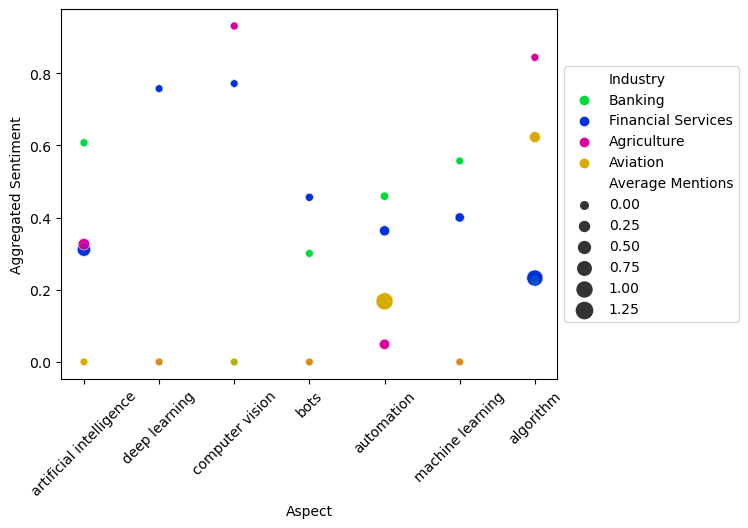

In [80]:
ax = sns.scatterplot(data=df_sentiments, x="Aspect", y="Aggregated Sentiment", size="Average Mentions", 
                palette=colors_hex, hue="Industry", legend=True, sizes=(30, 150), alpha=0.8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45)
plt.show()

In [30]:
df_tickers=pd.read_json('company_tickers.json').T
df_tickers.columns=['CIK', 'Ticker', 'Title']
df_tickers.drop("Title", axis=1, inplace=True)

df['CIK']=df['CIK'].astype(int)
df_tickers['CIK']=df_tickers['CIK'].astype(int)

df_full = df.merge(df_tickers, how='left', on='CIK')